# AdaBoost

This note introduces the **AdaBoost** algorithm using `scikit-learn`, explains the step-by-step logic behind how it works, and then demonstrates a from-scratch implementation to show that the core idea is intuitive and builds naturally on weak learners like Decision Stumps.

## What is AdaBoost?

**AdaBoost** (short for *Adaptive Boosting*) is an ensemble method that combines many **weak learners** into a strong one.  
Each weak learner is trained **sequentially**, with a focus on correcting the mistakes made by the previous ones.

Instead of training all learners on the same data:

- AdaBoost **reweights** the training samples after each round.
- Samples that are **misclassified** get **higher weights**, so the next learner pays more attention to them.
- Final predictions are made using a **weighted vote**, where more accurate learners contribute more.

> **AdaBoost** was introduced by Yoav Freund and Robert Schapire in 1996, and became the first practical boosting algorithm.

In this note, we focus on **binary classification** using decision stumps as weak learners.

This notebook will:

- **Use `scikit-learn`** to demonstrate how AdaBoost works in practice  
- **Explain the logic behind it** in a clear and intuitive way (reweighting, sequential learning, weighted voting)  
- **Show how to implement the algorithm step by step from scratch**, using decision stumps as base learners  

Let’s dive into the details to understand how it works and how to implement it ourselves.

## Preparation

We’ll use the classic **Iris dataset**, but filter it to create a **binary classification**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import plot_tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# --- Load Iris and filter to binary (Setosa vs. Versicolor) ---
X, y = load_iris(return_X_y=True)

# Change the mask to use classes 1 and 2 instead
mask = (y == 1) | (y == 2)
X_bin = X[mask]
y_bin = y[mask]

## Implement with Scikit-Learn

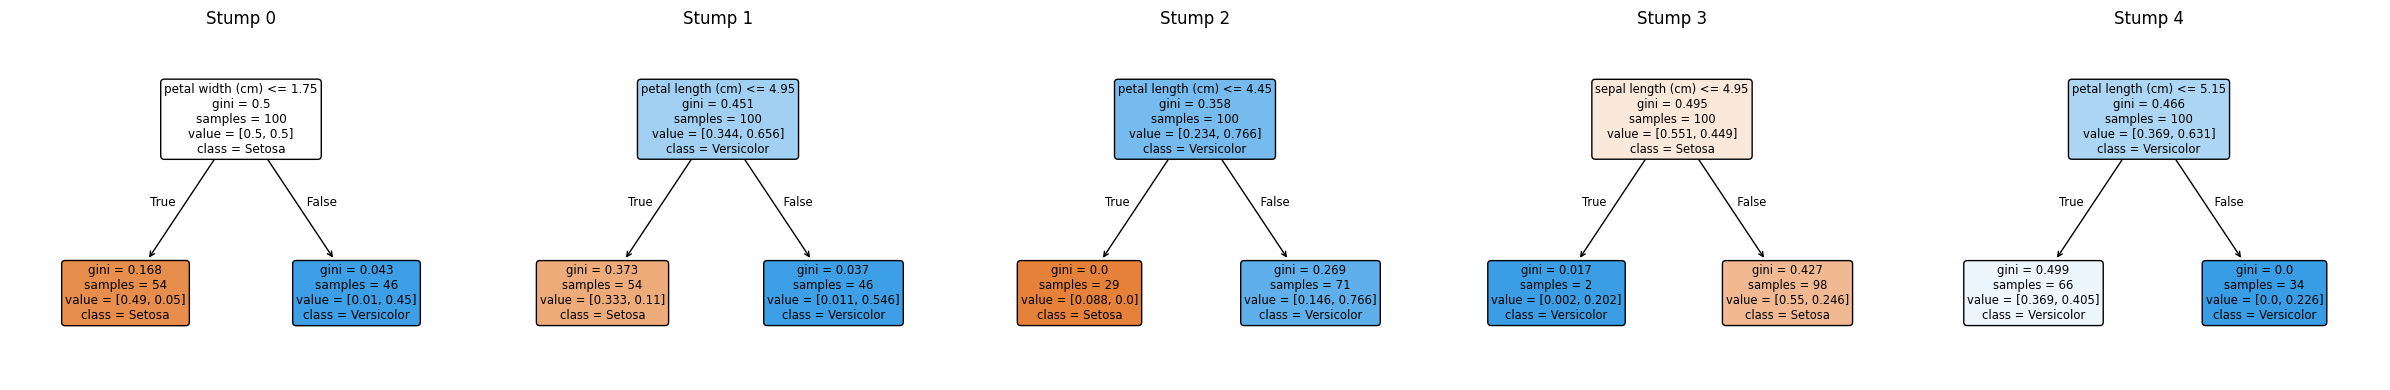

Stump 0 Accuracy = 0.9400
Stump 1 Accuracy = 0.9200
Stump 2 Accuracy = 0.7900
Stump 3 Accuracy = 0.5000
Stump 4 Accuracy = 0.5000
AdaBoost Accuracy (Ensemble) = 0.9600


In [ ]:
# Fit AdaBoost with 5 decision stumps
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=5,
    random_state=42
)
model.fit(X_bin, y_bin)

# Visualize stumps
fig, axes = plt.subplots(1, 5, figsize=(24, 4))
for i, ax in enumerate(model.estimators_):
    plot_tree(
        ax,
        feature_names=load_iris().feature_names,
        class_names=["Setosa", "Versicolor"],
        filled=True,
        rounded=True,
        ax=axes[i]
    )
    axes[i].set_title(f"Stump {i}")

plt.tight_layout()
plt.show()

# Accuracy of each stump
for i, stump in enumerate(model.estimators_):
    y_pred = stump.predict(X_bin)
    acc = accuracy_score(y_bin, y_pred)
    print(f"Stump {i} Accuracy = {acc:.4f}")

# Final ensemble prediction
y_pred_final = model.predict(X_bin)
acc_final = accuracy_score(y_bin, y_pred_final)
print(f"AdaBoost Accuracy (Ensemble) = {acc_final:.4f}")

## Understanding the Visualization

The diagram above shows **5 decision stumps** used in an AdaBoost ensemble.

Each stump:

- Is a **weak learner** with `max_depth = 1` — a single split (one decision boundary).
- Was trained on the **same dataset and features**, but with a different **emphasis (weighting)** on previously misclassified samples.
- Contributes to the final prediction via a **weighted vote**, based on how well it performed.

Together, they form a **sequential ensemble**, where each stump learns from the **mistakes of the previous ones**.  
As AdaBoost progresses, each new stump tries to fix errors made by the earlier ones.

> While some stumps perform only slightly better than chance, the final ensemble reaches a strong result by **combining their strengths**. In this case, even though some stumps have only 50–70% accuracy, the full AdaBoost model achieves **96% accuracy** — a major improvement over any single learner.

## Behind the Scenes

### 1. The Big Idea — One Split, One Update

AdaBoost builds a classifier **one step at a time**, using a simple rule — a **decision stump** (a tree with just one split).

Each new stump learns from the **mistakes** of the previous ones.  
To do this, AdaBoost keeps track of which training examples are **hard**, and gives those **more weight** in the next round.

> ✅ One split = one small step. AdaBoost slowly builds a strong classifier by stacking many tiny improvements.

### 2. Weighted Training — How It Works

Let’s break down how AdaBoost works **step by step**, including all formulas and intuitive explanations.

#### Step 1: Start with equal importance for all examples

Suppose you have $n$ training examples.  
In the beginning, each example is treated equally. So we give them equal weight:

$$
w_i = \frac{1}{n}
$$

**where:**

- $w_i$ is the weight (importance) of training example $i$

➡️ Yes, every **individual example** has its own weight.  
These weights change over rounds to shift focus to harder examples.

#### Step 2: Train a simple classifier (decision stump)

We train a **decision stump** $h_t(x)$ — a rule that splits the data once.  
It is trained **using the weights $w_i$**.

- At the beginning, all weights are equal.
- In later rounds, stumps will **focus more on the misclassified examples**, whose weights are higher.

#### Step 3: Measure how many mistakes it made (weighted)

We compute the **weighted error** of this stump:

$$
\varepsilon_t = \sum_{i=1}^{n} w_i \cdot \mathbb{1}[h_t(x_i) \ne y_i]
$$

**where:**

- $\varepsilon_t$ is the weighted error in round $t$
- $w_i$ is the current weight of training example $i$
- $h_t(x_i)$ is the predicted label (+1 or –1)
- $y_i$ is the true label
- $\mathbb{1}[h_t(x_i) \ne y_i]$ = 1 if the prediction is wrong, 0 if correct  
  (this is called the *indicator function*)

➡️ This formula adds up the **weights of only the misclassified examples**.  
It’s not about the number of mistakes, but how much **total weight** the mistakes carry.

> 🔍 For example, if $\varepsilon_t = 0.3$, that means 30% of the total weight was misclassified.

#### Step 4: Compute how strong the stump’s vote should be

We now calculate how much influence (confidence) this stump should have:

$$
\alpha_t = \frac{1}{2} \log\left(\frac{1 - \varepsilon_t}{\varepsilon_t}\right)
$$

**where:**

- $\alpha_t$ is the **vote weight** (confidence)
- $\varepsilon_t$ is the weighted error

➡️ The smaller the error, the higher the confidence.  
If $\varepsilon_t = 0.5$, then $\alpha_t = 0$ → **ignored**.  
If $\varepsilon_t > 0.5$, AdaBoost will **stop** — the stump is worse than guessing.

⚠️ These $\alpha_t$ values are **not normalized**. They don’t need to sum to 1.  
Each one simply reflects how good that particular stump is.

#### Step 5: Update the sample weights

Now we update the weights $w_i$ so the next stump focuses on the hard examples:

$$
w_i \leftarrow w_i \cdot \exp\left(-\alpha_t y_i h_t(x_i)\right)
$$

**where:**

- $y_i$ is the true label (+1 or –1)
- $h_t(x_i)$ is the predicted label (+1 or –1)
- If correct: $y_i h_t(x_i) = +1$ → exponent negative → $w_i$ gets **smaller**  
- If wrong: $y_i h_t(x_i) = -1$ → exponent positive → $w_i$ gets **larger**

After all $w_i$ are updated, we **normalize**:

$$
w_i \leftarrow \frac{w_i}{\sum_{j=1}^{n} w_j}
$$

➡️ This keeps the **sum of all weights equal to 1**, like a probability distribution:

$$
\sum_{i=1}^{n} w_i = 1
$$

This prevents weights from growing too large and keeps the scale stable across rounds.

### 3. Final Prediction — Confidence-Weighted Voting

Once all stumps are trained, the final prediction is made by a **weighted vote**:

$$
\text{final prediction} = \text{sign} \left( \sum_{t=1}^T \alpha_t \cdot h_t(x) \right)
$$

**where:**

- $h_t(x)$ is the predicted label (+1 or –1) from stump $t$
- $\alpha_t$ is the confidence vote weight

➡️ The sum is a real number — it could be +3.2, –1.5, etc.  
We use `sign(...)` to convert it into a final decision:

- Positive → Class +1  
- Negative → Class –1

> ✅ Unlike Random Forest, AdaBoost doesn’t count votes equally — it trusts better stumps more.

## Let's Code It

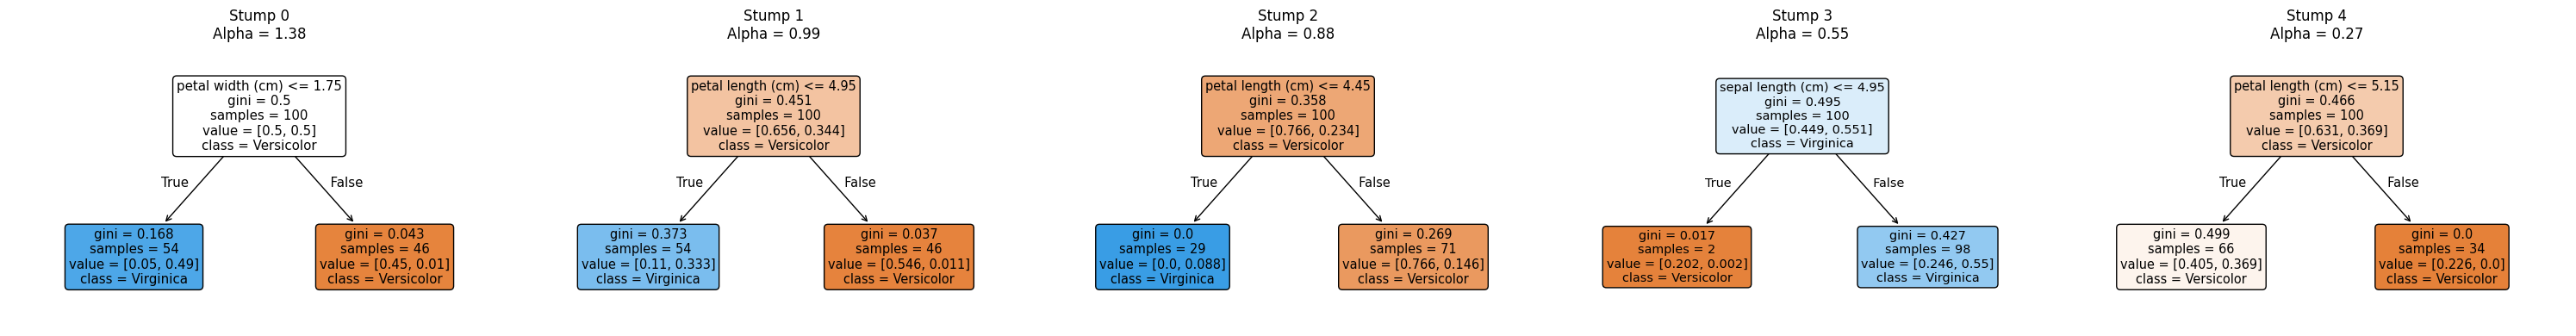

Stump 0 Accuracy = 0.9400
Stump 1 Accuracy = 0.9200
Stump 2 Accuracy = 0.7900
Stump 3 Accuracy = 0.5000
Stump 4 Accuracy = 0.5000

AdaBoost Accuracy (Final Ensemble) = 0.9600


In [ ]:
X, y = X_bin, y_bin
y = np.where(y == 1, 1, -1)  # Encode as +1 (Versicolor), -1 (Virginica)

n_samples = X.shape[0]
n_rounds = 5
random_state = np.random.RandomState(42)

# --- 2. Initialize weights w_i = 1 / n ---
weights = np.ones(n_samples) / n_samples  # w_i: importance of example i

# --- 3. Storage for stumps and their vote weights (alpha_t) ---
stumps = []
alphas = []

# --- 4. AdaBoost Loop: Train one stump per round ---
for t in range(n_rounds):
    # --- Train weak learner using current weights ---
    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X, y, sample_weight=weights)  # Train on full data, but using weighted loss

    # --- Predict all training samples ---
    y_pred = stump.predict(X)

    # --- Compute weighted error ε_t ---
    miss = (y_pred != y)                   # 1 if wrong, 0 if correct
    error = np.sum(weights[miss]) / np.sum(weights)  # ε_t = sum of w_i for misclassified samples

    # --- Compute alpha_t: stump's vote strength ---
    alpha = 0.5 * np.log((1 - error) / error)
    # Formula: α_t = 0.5 * log((1 - ε_t) / ε_t)
    # If error is small → alpha is large → strong vote

    # --- Update weights: w_i ← w_i * exp(-α_t * y_i * h_t(x_i)) ---
    # Correct prediction → weight goes down
    # Wrong prediction → weight goes up
    weights *= np.exp(-alpha * y * y_pred)

    # --- Normalize weights so sum(w_i) = 1 ---
    weights /= np.sum(weights)

    # --- Store the stump and its confidence ---
    stumps.append(stump)
    alphas.append(alpha)

# --- 5. Final AdaBoost Prediction Function ---
def adaboost_predict(X):
    weighted_votes = np.zeros(X.shape[0])
    for stump, alpha in zip(stumps, alphas):
        pred = stump.predict(X)            # Each h_t(x)
        weighted_votes += alpha * pred     # Add α_t * h_t(x)
    return np.sign(weighted_votes)         # Final prediction = sign of total

# --- 6. Visualize All Stumps ---
fig, axes = plt.subplots(1, n_rounds, figsize=(6 * n_rounds, 4))
for i, ax in enumerate(axes):
    plot_tree(
        stumps[i],
        feature_names=load_iris().feature_names,
        class_names=["Versicolor", "Virginica"],
        filled=True,
        rounded=True,
        ax=ax
    )
    ax.set_title(f"Stump {i}\nAlpha = {alphas[i]:.2f}")
plt.tight_layout()
plt.show()

# --- 7. Each Stump Accuracy ---
for i, stump in enumerate(stumps):
    y_pred = stump.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"Stump {i} Accuracy = {acc:.4f}")

# --- 7. Final Ensemble Accuracy ---
y_pred_final = adaboost_predict(X)
acc_final = accuracy_score(y, y_pred_final)
print(f"\nAdaBoost Accuracy (Final Ensemble) = {acc_final:.4f}")

## It Works!!

We successfully built an **AdaBoost Classifier** from scratch using `scikit-learn` Decision Trees.

- Each of the **5 stumps** was trained in sequence, using **reweighted data** to focus on the mistakes of the previous stump.
- Individually, some stumps performed modestly — but when combined with **confidence-weighted voting**, the ensemble reached high accuracy.

> This confirms that our logic — weighted training, adaptive focus on hard examples, and confidence-based aggregation — behaves exactly as expected.

We've successfully built a powerful **AdaBoost Ensemble Classifier** from the ground up!